# SBA

# import packages

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import sweetviz as sv
import missingno as msno
import time 
import sys
import os
import csv
from bs4 import BeautifulSoup
import requests
import re

![SBA](https://youth.gov/sites/default/files/2021-08/SBA-Formatted.gif)

## Read Data

In [98]:
#df = pd.read_csv('/home/apprenant/Documents/archive/SBAnational.csv')
df = pd.read_csv('C:/Users/emada/Downloads/loan_project (1)/SBAnational.csv')

<ipython-input-98-adfed659cc97>:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/Users/emada/Downloads/loan_project (1)/SBAnational.csv')


### Remove "A" in "ApprovalFY" column and replace it with "" then change type to int

In [99]:
%%timeit
df['ApprovalFY'] = df['ApprovalFY'].replace('A', '', regex=True).astype(int)

3.26 ms ± 553 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Creat sweetvis Repport
![sweetvis](https://warehouse-camo.ingress.cmh1.psfhosted.org/210c4eb7317c8b0d2e7d0784b1a9697c096050ef/687474703a2f2f636f6f6c74696d696e672e636f6d2f53562f4c61796f75742d416e696d332e676966)

In [100]:
# report = sv.analyze(df)
# report.show_html('report.html')


##  The target feature (y) is : MSI_Status (CHGOFF and PIF)

### Data cleaning

In [101]:
df.describe()

,LoanNr_ChkDgt,Zip,NAICS,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural
count,8.991640e+05,899164.000000,899164.000000,899164.000000,899164.000000,899164.000000,899028.000000,899164.000000,899164.000000,899164.000000,899164.000000
mean,4.772612e+09,53804.391241,398660.950146,2001.143560,110.773078,11.411353,1.280404,8.430376,10.797257,2753.725933,0.757748
std,2.538175e+09,31184.159152,263318.312759,5.913846,78.857305,74.108196,0.451750,236.688165,237.120600,12758.019136,0.646436
min,1.000014e+09,0.000000,0.000000,1962.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.589758e+09,27587.000000,235210.000000,1997.000000,60.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,4.361439e+09,55410.000000,445310.000000,2002.000000,84.000000,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000
75%,6.904627e+09,83704.000000,561730.000000,2006.000000,120.000000,10.000000,2.000000,1.000000,4.000000,1.000000,1.000000
max,9.996003e+09,99999.000000,928120.000000,2014.000000,569.000000,9999.000000,2.000000,8800.000000,9500.000000,99999.000000,2.000000


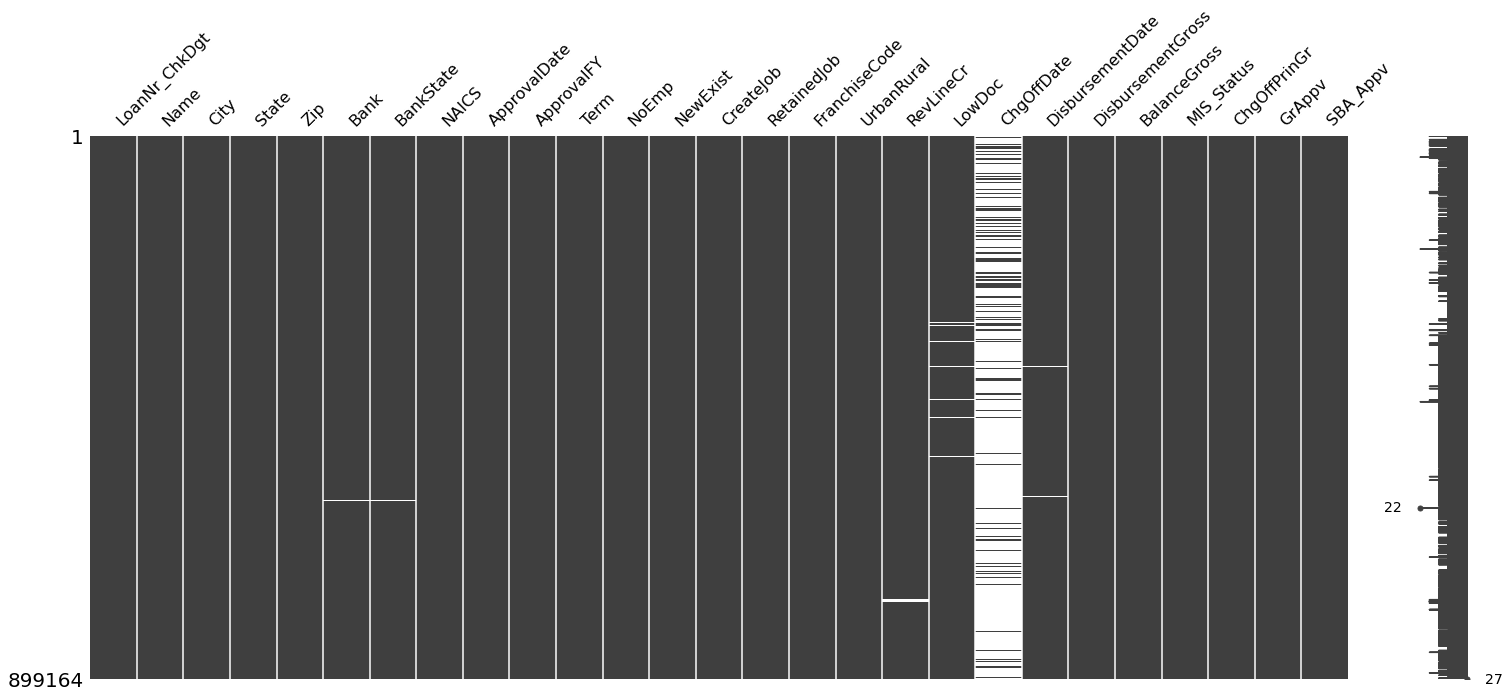

In [102]:
msno.matrix(df);

In [103]:
print(df.isnull().sum())

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64


### Replace "$" with "" in numeric columns

In [104]:
# create a list of all numeric columns
numeric_columns = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]

# use a for loop to remove "$" and replace it with nothing
for col in numeric_columns:
    if col in ["DisbursementGross","BalanceGross","ChgOffPrinGr","GrAppv","SBA_Appv"]:
        df[col] = df[col].str.replace("$", "")
        df[col] = df[col].str.replace(",", "")
        df[col] = pd.to_numeric(df[col])

### Find State's df missing values using Zip codes

In [107]:
def getCityState(zipCode):
    zipCode = str(zipCode)
    url = "http://www.city-data.com/zips/" + zipCode + ".html"
    r = requests.get(url)
    data = r.text
    soup = BeautifulSoup(data)
    if soup.findAll(text="City:") ==[]:
        cityNeeded = soup.findAll(text="Cities:")
        for t in cityNeeded:
            city_name = t.find_next('a').string
            if city_name:
                return city_name
                time.sleep(0.5)
    else:
        cityNeeded = soup.findAll(text="City:")
        for t in cityNeeded:
            city_name = t.find_next('a').string
            if city_name:
                return city_name
                time.sleep(0.5)
    return None


df['Zip'] = df['Zip'].astype(int)


# Find the rows where the 'State' column is missing
missing_state_rows = df[df['State'].isnull()]

# Use the 'apply' function to apply the 'getCityState' function to the 'Zip' column of the missing rows
missing_state_rows['State'] = missing_state_rows['Zip'].apply(lambda x: getCityState(x))

# Update the original DataFrame with the new values for the 'State' column
df.update(missing_state_rows)

df['State'] = df['State'].str[-2:]


df[df['State'].isna()]


<ipython-input-107-f2b32f71cbdf>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_state_rows['State'] = missing_state_rows['Zip'].apply(lambda x: getCityState(x))


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
35517,1.270833e+09,SO. JERSEY DANCE/MERRYLEES,PENNSVILLE,NaN,8070.0,NaN,NaN,0.0,28-Jul-81,1981.0,120.0,1.0,2.0,0.0,0.0,0.0,0.0,N,N,5-Mar-90,NaN,$0.00,$0.00,NaN,"$11,364.00","$15,000.00","$15,000.00"
49244,1.380800e+09,TRYON COATS & LEATHER,JOHNSTOWN NY,NaN,0.0,KEYBANK NATIONAL ASSOCIATION,NY,0.0,18-May-66,1966.0,282.0,0.0,0.0,0.0,0.0,0.0,0.0,N,N,29-Mar-90,16-Aug-66,"$60,000.00",$0.00,CHGOFF,"$6,084.00","$60,000.00","$54,000.00"
306274,3.113583e+09,THE COMPUTER EDGE,"BOX 267, APO AP",NaN,96205.0,RTC/WESTPORT SAVINGS BANK,CA,541511.0,21-Jan-88,1988.0,73.0,8.0,1.0,0.0,0.0,0.0,0.0,N,N,18-Sep-93,16-Mar-88,"$50,000.00",$0.00,CHGOFF,"$30,589.00","$50,000.00","$45,000.00"


### We still have 3 States missing values bescause of there non valide Zip code

## Drop not important features

In [111]:
cols_to_drop = ['LoanNr_ChkDgt', 'Name', 'City', 'Zip', 'Bank', 'BankState', 'DisbursementDate', 'ApprovalDate', 'ApprovalFY', 'ChgOffDate']
df.drop(columns=cols_to_drop, inplace=True)


## Drop from df all missing values in columne "MSI_Status"

In [114]:
df.dropna(subset=['MIS_Status'], inplace=True)


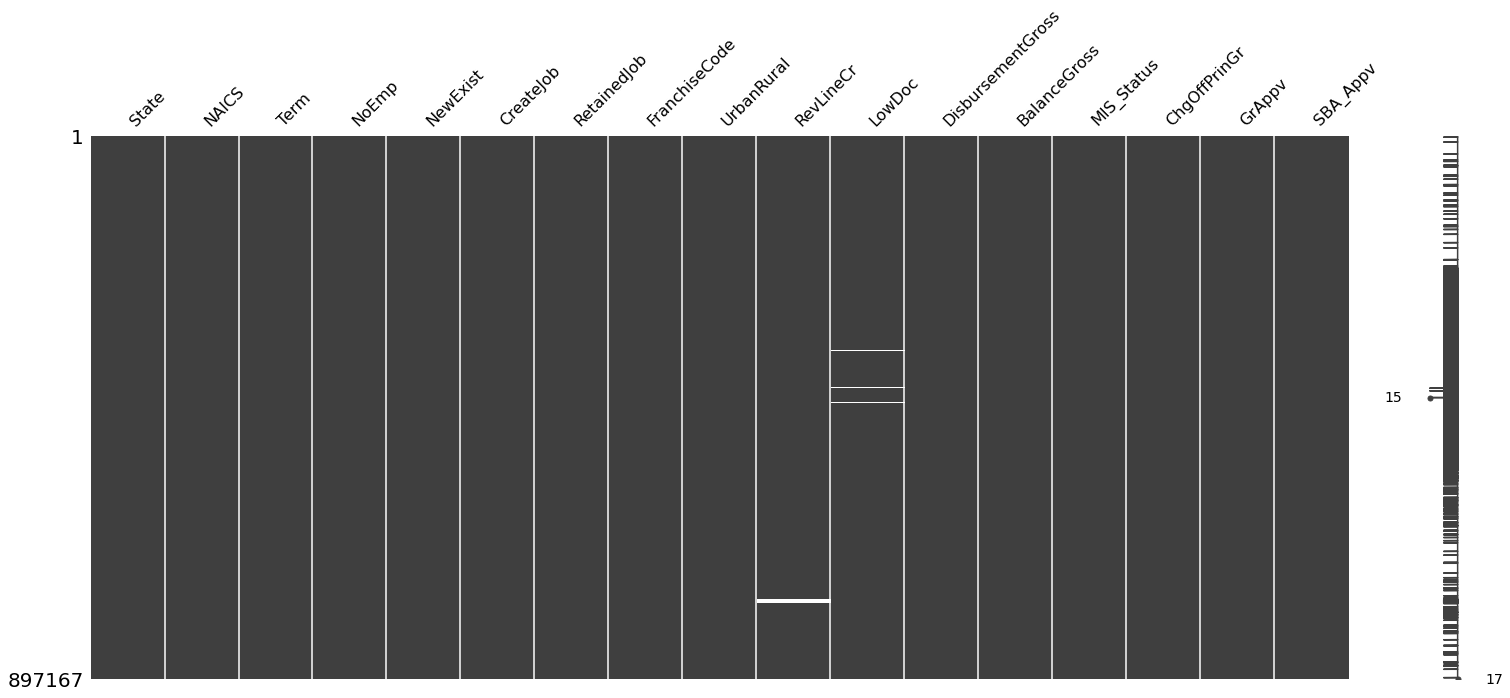

In [115]:
msno.matrix(df);

In [116]:
df.isna().sum()

State                   2
NAICS                   0
Term                    0
NoEmp                   0
NewExist              134
CreateJob               0
RetainedJob             0
FranchiseCode           0
UrbanRural              0
RevLineCr            4520
LowDoc               2578
DisbursementGross       0
BalanceGross            0
MIS_Status              0
ChgOffPrinGr            0
GrAppv                  0
SBA_Appv                0
dtype: int64